# Test Magnetogram Data
Sandbox for playing around with simulated magnetograms from the flux transport code.

In [84]:
import numpy as np
import scipy.io
import scipy.interpolate
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file
import synthesizAR
import sunpy.map
import sunpy.io.fits
import sunpy

%matplotlib inline

See if we can load output from Alison's flux transport code. The data is given in terms of $(\theta,\phi,F)$, where

* $0<\theta<\pi$ is latitude (should really vary like $-\pi/2<\theta<\pi/2$, but this is easily fixed),
* $0<\phi<2\pi$ is longitude, and 
* $F$ is the flux. 

This is essentially a *synoptic* map (I think). So we first need to transform this data into a synoptic map and then create a helioprojective magnetogram from that synoptic map.

In [136]:
tmp = scipy.io.readsav('/Users/willbarnes/Downloads/n001_166800.sav')

In [137]:
lon_data = np.array(tmp['phis'],dtype=np.float64)*180/np.pi
lat_data = (np.array(tmp['thetas'],dtype=np.float64) - np.pi/2.)*180/np.pi
flux_data = np.array(tmp['fluxs'],dtype=np.float64)

In [138]:
lon,lat = np.arange(0,360.01,0.1),np.arange(-90,90.01,0.1)
lon_grid,lat_grid = np.meshgrid(lon,lat)

In [139]:
flux_grid = scipy.interpolate.griddata(np.stack([lon_data,lat_data],axis=1), flux_data,
                                       (lon_grid,lat_grid), method='cubic', fill_value=0.)

In [140]:
(lat[-1]-lat[0])/2 + lat[0]

-5.1159076974727213e-12

In [131]:
lat

array([-90. , -89.9, -89.8, ...,  89.7,  89.8,  89.9])

In [128]:
lon.shape[0]/2

1800.0

Now, we want to convert this to a SunPy carrington map. We first need to create a sensible header.

In [145]:
header = sunpy.util.metadata.MetaDict({
    #'telescop': 'SDO/HMI',
    #'instrume': 'HMI_SIDE1',
    #'wavelnth': 6173.0,
    'crpix1': lon.shape[0]/2,
    'crpix2': lat.shape[0]/2,
    'crval1': (lon[-1]-lon[0])/2 + lon[0],
    'crval2': (lat[-1]-lat[0])/2 + lat[0],
    'cdelt1': np.diff(lon)[0],
    'cdelt2': np.diff(lat)[0],
    'cunit1': 'degree',
    'cunit2': 'degree',
    'wcsname': 'Carrington Heliographic',
    #'waveunit': 'Angstrom',
    #'detector': 'HMI',
    'content': 'Carrington synoptic chart of simulated flux transport'
})

In [146]:
ft_syn_map = sunpy.map.Map(flux_grid,header)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:275: Warning: Missing metadata for observation time. Using current time.
  w2.wcs.dateobs = self.date.isoformat()
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:632: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  return SkyCoord(lat=self.heliographic_latitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:610: Warning: Missing metadata for observation time. Using current time.
  heliographic_latitude = get_sun_B0(self.date)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:634: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  radius=self.dsun,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:432: Warning: Missing metadata for observation time.

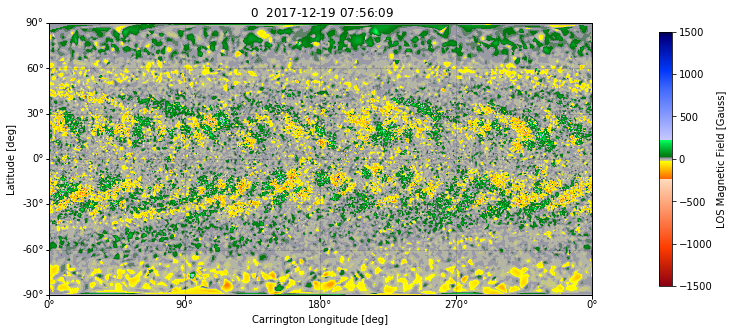

In [149]:
fig = plt.figure(figsize=(12,5))
axes = fig.add_subplot(111,projection=ft_syn_map)
im = ft_syn_map.plot(cmap=sunpy.cm.get_cmap('hmimag'),vmin=-1.5e3,vmax=1.5e3)
# Set up the Sine Latitude Grid
x = axes.coords[0]
y = axes.coords[1]

x.set_coord_type('longitude', coord_wrap=360.)
y.set_coord_type('latitude')

x.set_major_formatter('dd')
y.set_major_formatter('dd')

x.set_axislabel("Carrington Longitude [deg]")
y.set_axislabel("Latitude [deg]")

x.set_ticks(color='black', exclude_overlapping=True)
y.set_ticks(color='black', exclude_overlapping=True)

# Hide the grid
axes.coords.grid(color='black', alpha=0.6, linestyle='dotted', linewidth=0.5)

# Create a colorbar
cb = plt.colorbar(im, fraction=0.019, pad=0.1)
cb.set_label("LOS Magnetic Field [Gauss]")

## SunPy Synoptic Map Example

In [85]:
filename = download_file(
    'http://jsoc.stanford.edu/data/hmi/synoptic/hmi.Synoptic_Mr.2191.fits', cache=True)

In [86]:
syn_map = sunpy.map.Map(filename)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:774: Warning: Unknown value for CUNIT2
  Warning)


In [87]:
syn_map.meta

MetaDict([('simple', True),
          ('bitpix', -32),
          ('naxis', 2),
          ('naxis1', 3600),
          ('naxis2', 1440),
          ('extend', True),
          ('comment',
           "FITS (Flexible Image Transport System) format is defined in 'Astronomy  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"),
          ('date', '2017-06-29T00:00:00'),
          ('telescop', 'SDO/HMI'),
          ('instrume', 'HMI_SIDE1'),
          ('wavelnth', 6173.0),
          ('bunit', 'Mx/cm^2'),
          ('content', 'Carrington Synoptic Chart Of Br Field'),
          ('history',
           'Carrington-Time conversion corrected; o2helio.c bug corrected -- July 2013'),
          ('bld_vers', -2147483648),
          ('ctype1', 'CRLN-CEA'),
          ('ctype2', 'CRLT-CEA'),
          ('crpix1', 1800.0),
          ('crpix2', 720.5),
          ('crval1', 788580.0),
          ('crval2', 0.0),
          ('cdelt1', -0.1),
          ('cdelt2', 0.001389),
          ('cunit1',

In [104]:
syn_map.meta['CUNIT2'] = 'degree'
syn_map.meta['CDELT2'] = 180 / np.pi * syn_map.meta['CDELT2']
syn_map.meta['CDELT1'] *= -1

In [109]:
syn_map.meta['CDELT2']

0.07958383774367135

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:275: Warning: Missing metadata for observation time. Using current time.
  w2.wcs.dateobs = self.date.isoformat()
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:632: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  return SkyCoord(lat=self.heliographic_latitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:610: Warning: Missing metadata for observation time. Using current time.
  heliographic_latitude = get_sun_B0(self.date)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:634: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  radius=self.dsun,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:432: Warning: Missing metadata for observation time.

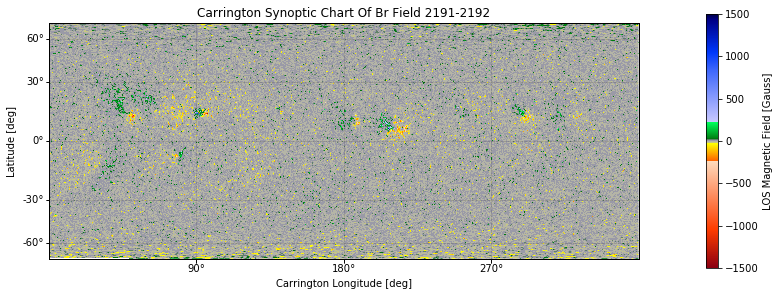

In [105]:
syn_map.plot_settings['cmap'] = 'hmimag'
syn_map.plot_settings['norm'] = plt.Normalize(-1500, 1500)
fig = plt.figure(figsize=(12, 5))
axes = plt.subplot(projection=syn_map)

# Plot the image
im = syn_map.plot()

# Set up the Sine Latitude Grid
x = axes.coords[0]
y = axes.coords[1]

x.set_coord_type('longitude', coord_wrap=360.)
y.set_coord_type('latitude')

x.set_major_formatter('dd')
y.set_major_formatter('dd')

x.set_axislabel("Carrington Longitude [deg]")
y.set_axislabel("Latitude [deg]")

x.set_ticks(color='black', exclude_overlapping=True)
y.set_ticks(color='black', exclude_overlapping=True)

# Hide the grid
axes.coords.grid(color='black', alpha=0.6, linestyle='dotted', linewidth=0.5)

# Create a colorbar
cb = plt.colorbar(im, fraction=0.019, pad=0.1)
cb.set_label("LOS Magnetic Field [Gauss]")

# Another horrible hack to make the ticks draw on the RHS
axes.set_ylim((1, syn_map.data.shape[0] - 1))

plt.title("{} {}-{}".format(syn_map.meta['content'], syn_map.meta['CAR_ROT'],
                            syn_map.meta['CAR_ROT'] + 1))

## Converter Between `.sav` to `sunpy.map.Map` 

In [151]:
def ftc_sav_to_map(filename, res_lon=0.1, res_lat=0.1):
    # Read in data
    tmp = scipy.io.readsav(filename)
    # Convert coordinates to lat/lon in degrees
    lon_data = np.array(tmp['phis'],dtype=np.float64)*180/np.pi
    lat_data = (np.array(tmp['thetas'],dtype=np.float64) - np.pi/2.)*180/np.pi
    flux_data = np.array(tmp['fluxs'],dtype=np.float64)
    # Create grid
    lon,lat = np.arange(0, 360+res_lon, res_lon), np.arange(-90, 90+res_lat, res_lat)
    lon_grid,lat_grid = np.meshgrid(lon,lat)
    # Interpolate to grid
    flux_grid = scipy.interpolate.griddata(np.stack([lon_data, lat_data],axis=1),
                                           flux_data, (lon_grid,lat_grid),
                                           method='cubic', fill_value=0.)
    # Build header
    header = sunpy.util.metadata.MetaDict({
        'crpix1': lon.shape[0]/2,
        'crpix2': lat.shape[0]/2,
        'crval1': (lon[-1]-lon[0])/2 + lon[0],
        'crval2': (lat[-1]-lat[0])/2 + lat[0],
        'cdelt1': np.diff(lon)[0],
        'cdelt2': np.diff(lat)[0],
        'cunit1': 'degree',
        'cunit2': 'degree',
        'wcsname': 'Carrington Heliographic',
        'content': 'Carrington synoptic chart of simulated flux transport'
    })
    lim = max(flux_grid.max(),np.fabs(flux_grid.min()))
    
    return sunpy.map.Map(flux_grid, header, plot_settings={'cmap':'hmimag','norm':plt.Normalize(vmin=-lim,vmax=lim)})

In [159]:
flux_map1 = ftc_sav_to_map('/Users/willbarnes/Downloads/n001_178800.sav')

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:275: Warning: Missing metadata for observation time. Using current time.
  w2.wcs.dateobs = self.date.isoformat()
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:632: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  return SkyCoord(lat=self.heliographic_latitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:610: Warning: Missing metadata for observation time. Using current time.
  heliographic_latitude = get_sun_B0(self.date)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:634: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  radius=self.dsun,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:432: Warning: Missing metadata for observation time.

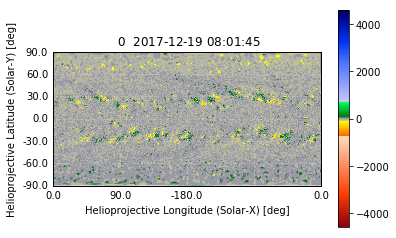

In [160]:
flux_map1.peek()

In [161]:
flux_map1.meta

MetaDict([('crpix1', 1800.5),
          ('crpix2', 900.5),
          ('crval1', 180.0),
          ('crval2', -5.1159076974727213e-12),
          ('cdelt1', 0.10000000000000001),
          ('cdelt2', 0.099999999999994316),
          ('cunit1', 'degree'),
          ('cunit2', 'degree'),
          ('wcsname', 'Carrington Heliographic'),
          ('content', 'Carrington synoptic chart of simulated flux transport'),
          ('naxis1', 3601),
          ('naxis2', 1801),
          ('naxis', 2)])

## HMI Map

Now, read in an HMI FITS file to see how we need to modify the simulation example to get it into the right format.

In [ ]:
hmi_pairs = sunpy.io.fits.read('/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits')